# 00 数据探索 (EDA)
- 统计数量/尺寸
- 标签颜色模式检查
- 随机可视化
- 简单损坏检测



In [1]:
from pathlib import Path
import json
import random
import itertools
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Notebook 运行目录默认在 notebooks/，需要回到项目根读取 data
ROOT = Path("..").resolve() / "data"
PROCESSED = ROOT / "processed"
SPLIT_FILE = ROOT / "splits" / "cityscapes_split_seed42.json"

with SPLIT_FILE.open("r", encoding="utf-8") as f:
    splits = json.load(f)

print("loaded splits:", {k: len(v) for k, v in splits.items()})


loaded splits: {'train': 2975, 'val': 500}


In [4]:
def count_per_split(split: str):
    files = splits[split]
    photo_dir = PROCESSED / split / "photo"
    label_dir = PROCESSED / split / "label"
    print(f"[{split}] count: {len(files)}, photo_dir={photo_dir}, label_dir={label_dir}")
    missing = []
    for name in itertools.islice(files, 0, 1000):  # 先抽前200个简单检查
        stem = Path(name).stem
        if not (photo_dir / f"{stem}_photo.jpg").exists():
            missing.append(name)
        if not (label_dir / f"{stem}_label.png").exists():
            missing.append(name)
    print(f"  missing in first200: {len(missing)}")

count_per_split("train")
count_per_split("val")


[train] count: 2975, photo_dir=C:\Users\23208\Desktop\Image-to-Image-Translation-Experiment\data\processed\train\photo, label_dir=C:\Users\23208\Desktop\Image-to-Image-Translation-Experiment\data\processed\train\label
  missing in first200: 0
[val] count: 500, photo_dir=C:\Users\23208\Desktop\Image-to-Image-Translation-Experiment\data\processed\val\photo, label_dir=C:\Users\23208\Desktop\Image-to-Image-Translation-Experiment\data\processed\val\label
  missing in first200: 0


In [5]:
def size_distribution(split: str, max_samples: int = 400):
    files = splits[split]
    photo_dir = PROCESSED / split / "photo"
    sizes = []
    sample_names = random.sample(files, min(len(files), max_samples))
    for name in sample_names:
        stem = Path(name).stem
        with Image.open(photo_dir / f"{stem}_photo.jpg") as img:
            sizes.append(img.size)
    counter = Counter(sizes)
    top = counter.most_common(5)
    print(f"[{split}] size top5 (sample {len(sample_names)}): {top}")
    return counter

random.seed(42)
train_sizes = size_distribution("train")
val_sizes = size_distribution("val")


[train] size top5 (sample 400): [((256, 256), 400)]
[val] size top5 (sample 400): [((256, 256), 400)]


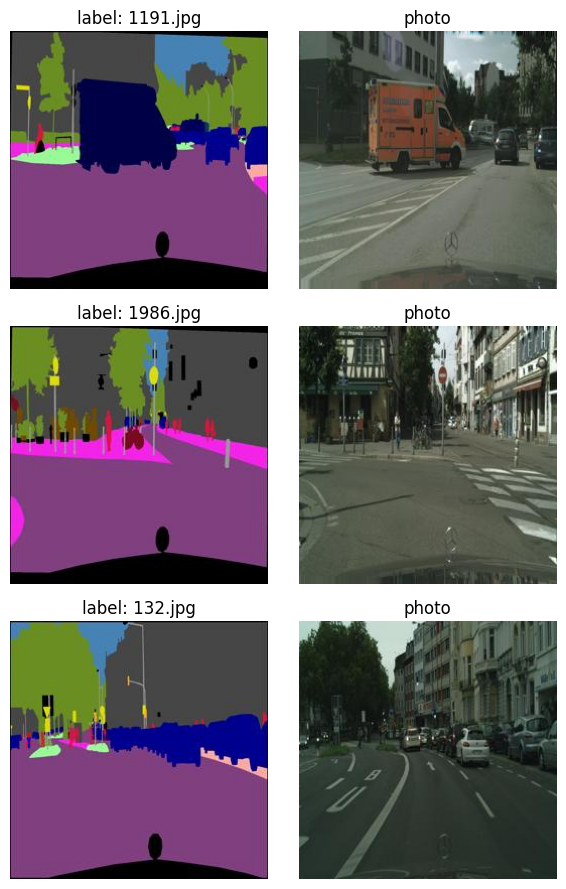

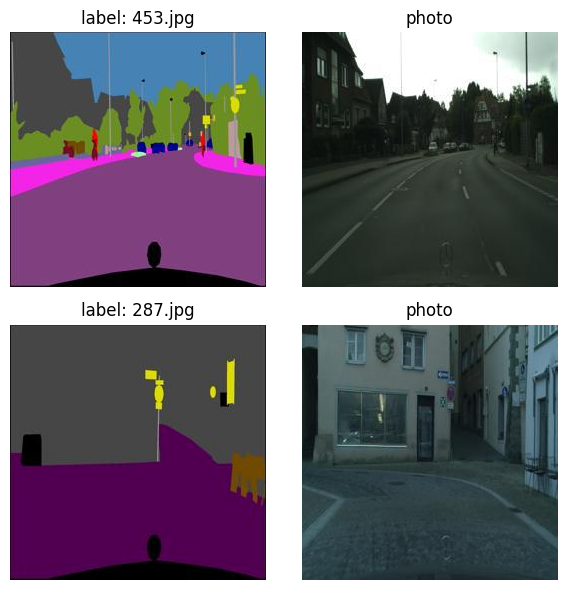

In [6]:
def show_samples(split: str, k: int = 3):
    files = splits[split]
    photo_dir = PROCESSED / split / "photo"
    label_dir = PROCESSED / split / "label"
    names = random.sample(files, k)
    fig, axes = plt.subplots(k, 2, figsize=(6, 3 * k))
    for idx, name in enumerate(names):
        stem = Path(name).stem
        with Image.open(label_dir / f"{stem}_label.png") as lbl, Image.open(photo_dir / f"{stem}_photo.jpg") as img:
            axes[idx, 0].imshow(lbl)
            axes[idx, 0].set_title(f"label: {name}")
            axes[idx, 0].axis("off")
            axes[idx, 1].imshow(img)
            axes[idx, 1].set_title("photo")
            axes[idx, 1].axis("off")
    plt.tight_layout()
    plt.show()

random.seed(123)
show_samples("train", k=3)
show_samples("val", k=2)


In [7]:
def corruption_check(split: str, max_samples: int = 300):
    files = splits[split]
    photo_dir = PROCESSED / split / "photo"
    label_dir = PROCESSED / split / "label"
    names = random.sample(files, min(len(files), max_samples))
    bad = []
    for name in names:
        stem = Path(name).stem
        try:
            with Image.open(photo_dir / f"{stem}_photo.jpg") as img:
                img.verify()
            with Image.open(label_dir / f"{stem}_label.png") as lbl:
                lbl.verify()
        except Exception as e:  # noqa: BLE001
            bad.append((name, str(e)))
    print(f"[{split}] corruption check on {len(names)} samples -> bad: {len(bad)}")
    if bad:
        print(bad[:5])

random.seed(2025)
corruption_check("train", max_samples=500)
corruption_check("val", max_samples=200)


[train] corruption check on 500 samples -> bad: 0
[val] corruption check on 200 samples -> bad: 0


In [8]:
# 模式统计与标签颜色唯一值
from collections import Counter

summary = {}
for split in ("train", "val"):
    photo_dir = PROCESSED / split / "photo"
    label_dir = PROCESSED / split / "label"
    files = splits[split]
    size_counter = Counter()
    photo_modes = Counter()
    label_modes = Counter()
    for name in files:
        stem = Path(name).stem
        with Image.open(photo_dir / f"{stem}_photo.jpg") as p:
            size_counter[p.size] += 1
            photo_modes[p.mode] += 1
        with Image.open(label_dir / f"{stem}_label.png") as l:
            label_modes[l.mode] += 1
    summary[split] = {
        "count": len(files),
        "sizes": size_counter.most_common(3),
        "photo_modes": photo_modes,
        "label_modes": label_modes,
    }

print("split summary:")
for k, v in summary.items():
    print(k, v)

# 抽样查看标签颜色数量
random.seed(42)
for split in ("train", "val"):
    files = random.sample(splits[split], 3)
    label_dir = PROCESSED / split / "label"
    print(f"unique colors sample for {split}:")
    for name in files:
        stem = Path(name).stem
        with Image.open(label_dir / f"{stem}_label.png") as l:
            uniq = len(set(l.convert("RGB").getdata()))
            print(f"  {name}: unique colors = {uniq}")



split summary:
train {'count': 2975, 'sizes': [((256, 256), 2975)], 'photo_modes': Counter({'RGB': 2975}), 'label_modes': Counter({'RGB': 2975})}
val {'count': 500, 'sizes': [((256, 256), 500)], 'photo_modes': Counter({'RGB': 500}), 'label_modes': Counter({'RGB': 500})}
unique colors sample for train:
  679.jpg: unique colors = 17967
  1409.jpg: unique colors = 13185
  1090.jpg: unique colors = 10435
unique colors sample for val:
  440.jpg: unique colors = 16445
  225.jpg: unique colors = 12389
  211.jpg: unique colors = 15403


In [9]:
# 保存统计表与可视化到项目根的 outputs/figures
import csv
from datetime import datetime

out_dir = (ROOT.parent / "outputs" / "figures").resolve()
out_dir.mkdir(parents=True, exist_ok=True)

def export_summary(summary_dict, path):
    with open(path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["split", "count", "sizes_top3", "photo_modes", "label_modes", "timestamp"])
        ts = datetime.now().isoformat(timespec="seconds")
        for split, info in summary_dict.items():
            writer.writerow([
                split,
                info["count"],
                info["sizes"],
                dict(info["photo_modes"]),
                dict(info["label_modes"]),
                ts,
            ])

# 依赖上一单元生成的 summary
export_summary(summary, out_dir / "eda_summary.csv")


def save_samples(split: str, k: int, filename: str):
    files = splits[split]
    photo_dir = PROCESSED / split / "photo"
    label_dir = PROCESSED / split / "label"
    names = random.sample(files, k)
    fig, axes = plt.subplots(k, 2, figsize=(6, 3 * k))
    for idx, name in enumerate(names):
        stem = Path(name).stem
        with Image.open(label_dir / f"{stem}_label.png") as lbl, Image.open(photo_dir / f"{stem}_photo.jpg") as img:
            axes[idx, 0].imshow(lbl)
            axes[idx, 0].set_title(f"label: {name}")
            axes[idx, 0].axis("off")
            axes[idx, 1].imshow(img)
            axes[idx, 1].set_title("photo")
            axes[idx, 1].axis("off")
    plt.tight_layout()
    plt.savefig(out_dir / filename, dpi=120)
    plt.close(fig)

random.seed(2025)
save_samples("train", k=4, filename="eda_samples_train.png")
save_samples("val", k=3, filename="eda_samples_val.png")
print("Saved summary and figures to", out_dir)



Saved summary and figures to C:\Users\23208\Desktop\Image-to-Image-Translation-Experiment\outputs\figures


运行提示：
- 在项目根目录启动 Jupyter/VS Code Notebook 运行本文件。
- 若需全量尺寸统计，将 `max_samples` 参数调大或移除采样限制。
- 若想保存可视化结果，可在 `show_samples` 中调用 `plt.savefig`。
